In [1]:
import sys
sys.path.append('../libs')


In [2]:
import numpy as np
import pandas as pd
import data_lib, plot_lib, decision_lib, validation_lib, transform_lib
from sklearn import cluster, mixture

np.random.seed(200)

In [3]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [10]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", 
                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-B3",  
                                     #"wa-sa-B2",
                                     #"wa-sa-A5", 
                                     #"wa-sa-A3",
                                     #"wa-sa-C2",
                                     #"wa-sa-C3", # Pos
                                     #"wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-B1", 
                                     #"wa-sa-A4",
                                     #"wa-sa-A1", 
                                     #"wa-sa-D2",
                                     "wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [26]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
#cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterRelativeHierarchyMeanClassifier(
                                     cluster_algorithm=cluster_engine,
                                     #negative_control = np_negative_control,
                                     whitening_transformer=whitening_engine,
                                     #negative_range=0.95,
                                     eps=None,
                                     contamination=0.0000000004,
                                     prediction_axis=prediction_axis
                                     )

In [27]:
df_decision = decision.predict(np_wa)

Number of neg removals: 4775
Outliers: 1
Zero dimensions: [False False False False False False]
Clusters: 24
Clusters: 23
[array([ 4489.73409462,  5261.8319739 ,  4577.18760196, 16229.43066884,
        3504.01631321,  5023.30831974]), array([4569.08724832, 5717.42281879, 3684.95302013, 3132.54362416,
       3882.06040268, 5465.04026846]), array([4511.144641  , 7012.73881374, 8083.21436004, 3062.58376691,
       3441.10093652, 5014.566077  ]), array([11597.83333333, 12065.83333333,  4539.41666667, 15470.75      ,
        3562.        ,  5054.75      ]), array([ 4769.20336134, 14098.32436975,  6474.87058824,  3036.5512605 ,
        3435.9394958 ,  5022.59831933]), array([ 4529.13407821,  5267.79888268,  3346.46927374,  3027.76536313,
        4417.16759777, 36246.09497207]), array([ 4494.08324769,  5223.40390545,  3338.15827338,  3135.8036999 ,
       19533.79136691, 15444.35354573]), array([11344.96917808, 11963.85958904,  3354.9880137 ,  2997.66609589,
        3448.08219178,  5025.93321

In [28]:
decision.neg_dimensions

array([False, False, False, False, False, False])

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.010977476492455718, n_outlier: 251

Total error rate: 0.008696677574363963
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.047095     0.000929    0.00398        0.0   0.000177      0.0

Precision (TP / (TP + FP)): 0.8030431107354185
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.442408     0.988623   0.920914        1.0        1.0      1.0

Recall / TPR (TP / (TP + FN)): 0.9968520461699895
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0       0.9875        1.0        1.0   0.996393      1.0

Specificity / TNR (TN / (TN + FP)): 0.9911013680214483
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.951077      0.99954   0.995827        1.0        1.0      1.0

Accuracy ((TP + TN) / (P + N)): 0.991303322425636
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.952905     0.999071    0.99602        1.0   0.999823      1.0

F1 (2 * (precision * r

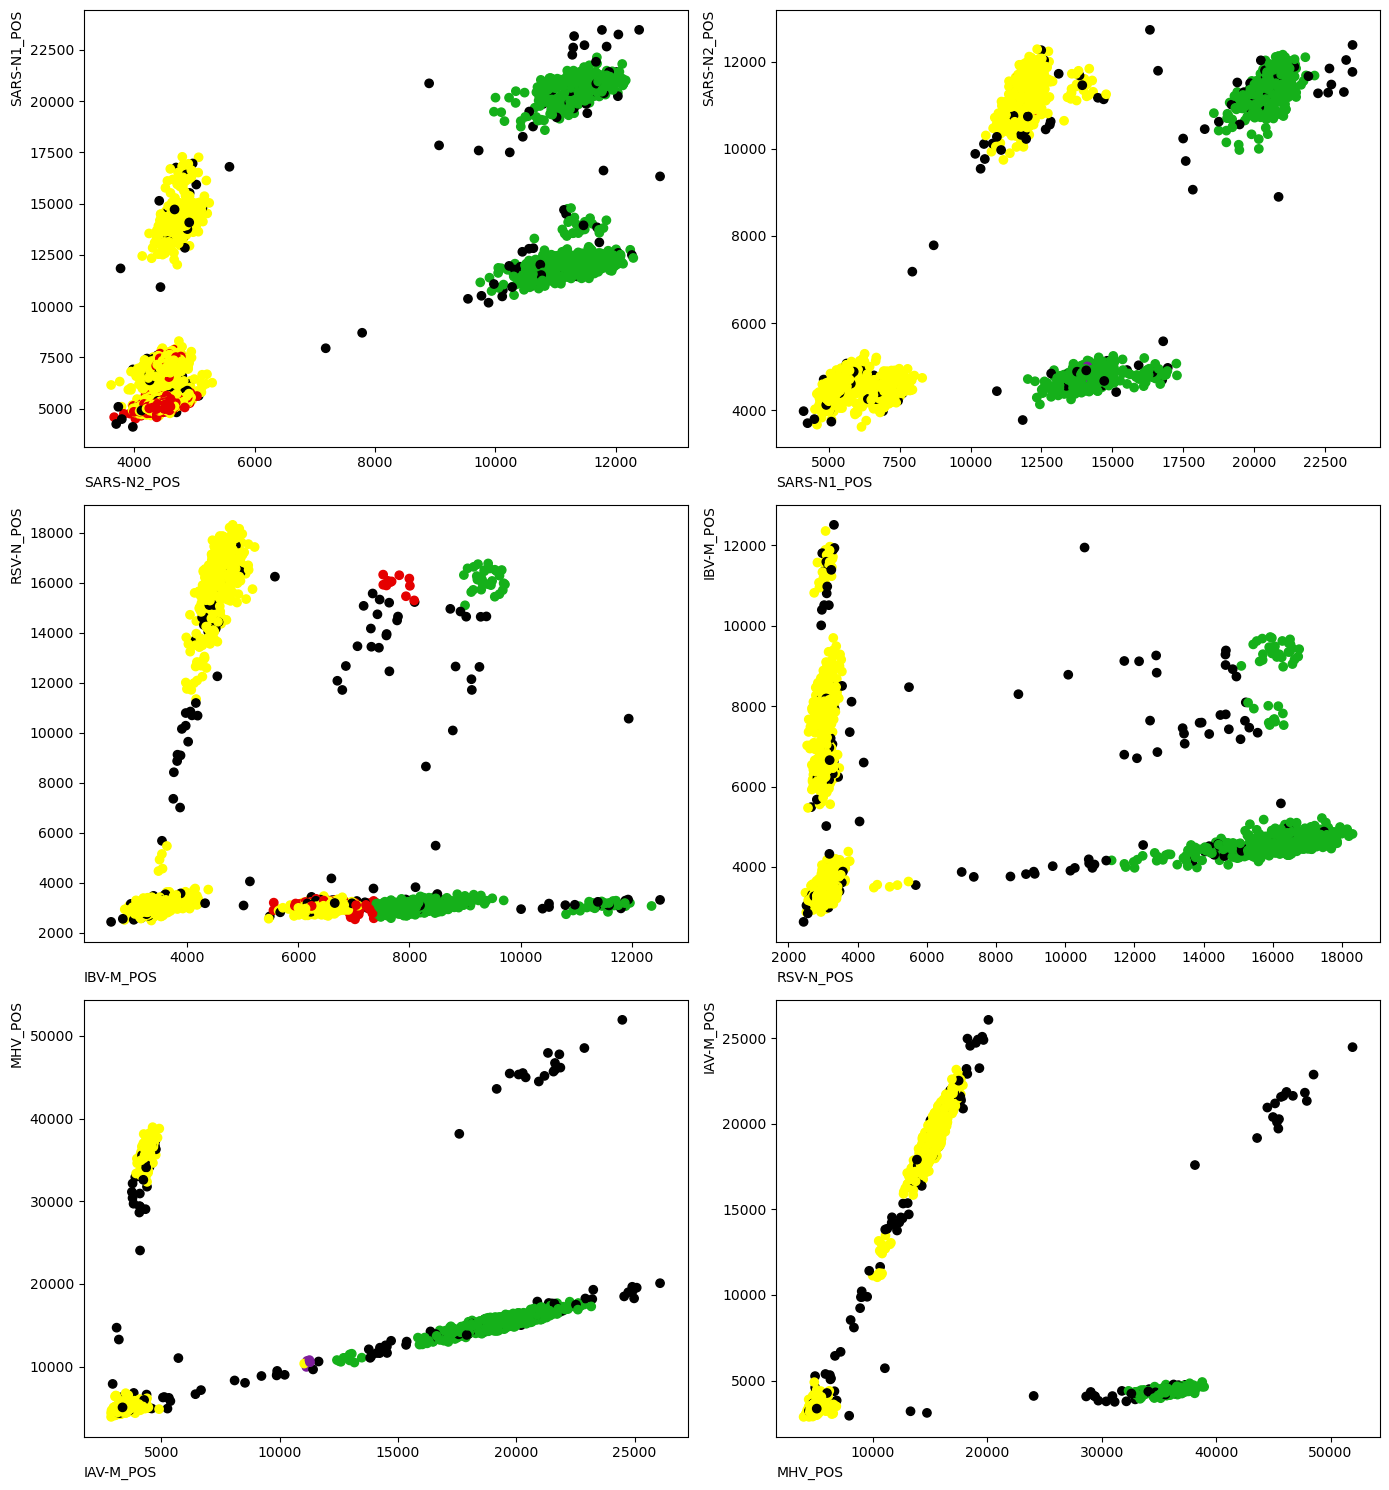

In [29]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.predictions_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]
mask = decision.No_neg_mask

validation_lib.validate_labels(df_wa, df_decision)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

### Error inspection

print only cluster with missclassifications

ic| cluster: -1.0, dim: 'IAV-M_POS', n_cluster - n_true: 131
ic| cluster: 19.0, dim: 'IAV-M_POS', n_cluster - n_true: 4
ic| cluster: -1.0, dim: 'MHV_POS', n_cluster - n_true: 201
ic| cluster: -1.0, dim: 'SARS-N1_POS', n_cluster - n_true: 175
ic| cluster: 18.0, dim: 'SARS-N1_POS', n_cluster - n_true: 11
ic| cluster: 20.0, dim: 'SARS-N1_POS', n_cluster - n_true: 10
ic| cluster: -1.0, dim: 'SARS-N2_POS', n_cluster - n_true: 170
ic| cluster: 6.0, dim: 'SARS-N2_POS', n_cluster - n_true: 973
ic| cluster: 10.0, dim: 'SARS-N2_POS', n_cluster - n_true: 34
ic| cluster: 11.0, dim: 'SARS-N2_POS', n_cluster - n_true: 5
ic| cluster: 12.0, dim: 'SARS-N2_POS', n_cluster - n_true: 48
ic| cluster: 19.0, dim: 'SARS-N2_POS', n_cluster - n_true: 5
ic| cluster: -1.0, dim: 'IBV-M_POS', n_cluster - n_true: 200
ic| cluster: 2.0, dim: 'IBV-M_POS', n_cluster - n_true: 54
ic| cluster: 15.0, dim: 'IBV-M_POS', n_cluster - n_true: 25
ic| cluster: 18.0, dim: 'IBV-M_POS', n_cluster - n_true: 11
ic| cluster: -1.0, dim:

(Partially) falsely classified clusters [-1.  2.  6. 10. 11. 12. 15. 18. 19. 20.]


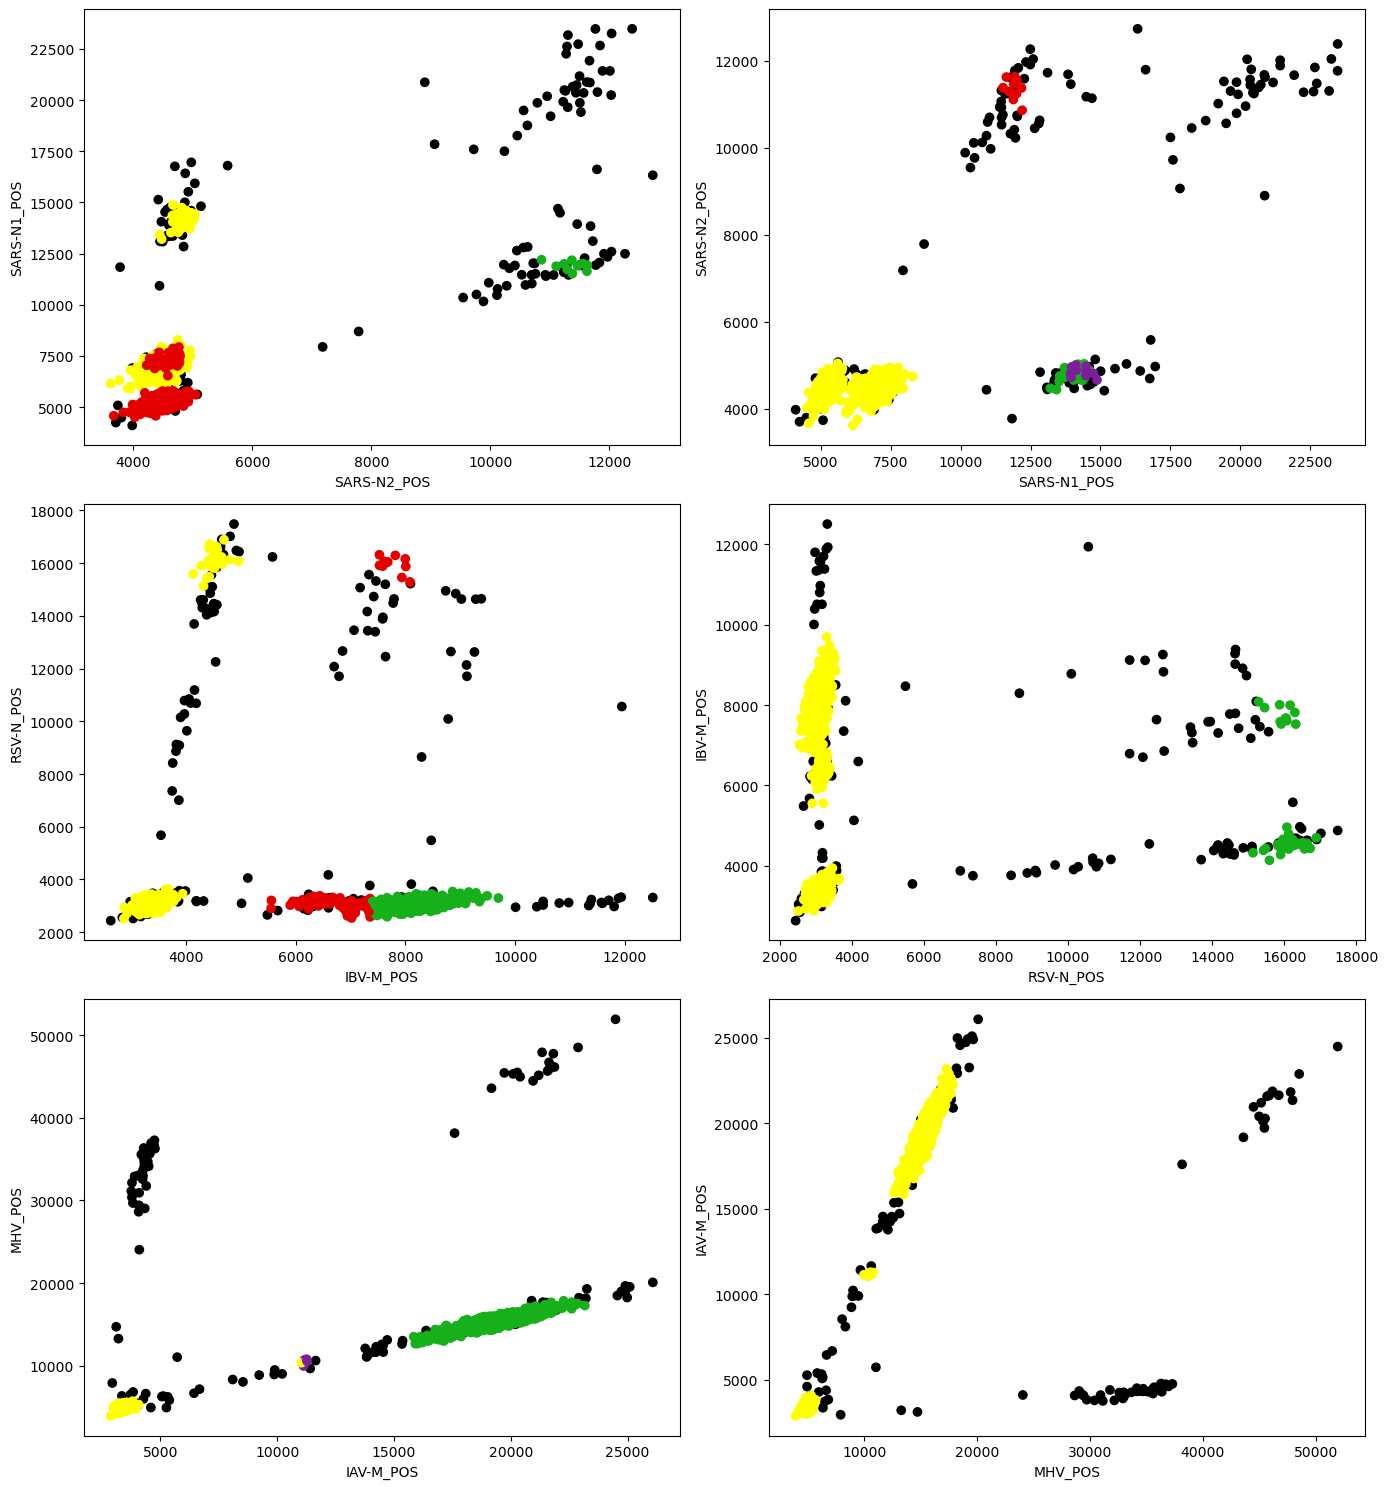

In [30]:
diseases = ["IAV-M_POS", "MHV_POS", "SARS-N1_POS", "SARS-N2_POS", "IBV-M_POS", "RSV-N_POS"]
false_clusters = validation_lib.get_false_clusters(clusters=decision.cluster_dict,
                                  df_true_labels=df_ground_trouth,
                                  df_predictions=df_predictions,
                                  disease=diseases,
                                  threshold=0.99)
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)